### import required packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix
from sklearn.linear_model import LogisticRegressionCV 
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from xgboost import XGBClassifier 
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import TruncatedSVD

import pickle
from warnings import filterwarnings
filterwarnings("ignore")

### Data ingestion

In [2]:
df=pd.read_csv('Final_movie_reviews_dataset.csv')

In [3]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### Drop Duplicates

In [4]:
df.drop_duplicates(inplace=True)

In [5]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
66792,"It's not about safety, it's about honour. \r\...",positive
66793,"""Harold"" (Bob Hoskins) has spent the last ten ...",negative
66794,"I've always been a bad guy, and a bad gambler....",positive
66795,I think I used to like musicals more than I do...,negative


### Exploratory Data Analysis (EDA)

In [6]:
df.sentiment.value_counts()

sentiment
positive    36113
negative    30684
Name: count, dtype: int64

<Axes: ylabel='count'>

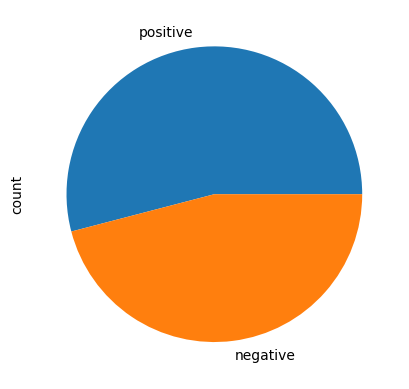

In [7]:
df.sentiment.value_counts().plot(kind="pie")

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66797 entries, 0 to 66796
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     66797 non-null  object
 1   sentiment  66797 non-null  object
dtypes: object(2)
memory usage: 1.0+ MB


In [9]:
df.isna().sum()

review       0
sentiment    0
dtype: int64

In [10]:
#since there is no NA value present in dataset, so need to drop any row

In [11]:
df.describe()

,review,sentiment
count,66797,66797
unique,66797,2
top,Despite the reported controversy over who play...,positive
freq,1,36113


In [12]:
# All reviews are unique 

### Text preprocessing

In [13]:
A=df['review']

In [14]:
A

0        One of the other reviewers has mentioned that ...
1        A wonderful little production. <br /><br />The...
2        I thought this was a wonderful way to spend ti...
3        Basically there's a family where a little boy ...
4        Petter Mattei's "Love in the Time of Money" is...
                               ...                        
66792    It's not about safety, it's about honour.  \r\...
66793    "Harold" (Bob Hoskins) has spent the last ten ...
66794    I've always been a bad guy, and a bad gambler....
66795    I think I used to like musicals more than I do...
66796    Despite the reported controversy over who play...
Name: review, Length: 66797, dtype: object

#### 1) Lowercasing

In [15]:
A=A.str.lower()

In [16]:
A

0        one of the other reviewers has mentioned that ...
1        a wonderful little production. <br /><br />the...
2        i thought this was a wonderful way to spend ti...
3        basically there's a family where a little boy ...
4        petter mattei's "love in the time of money" is...
                               ...                        
66792    it's not about safety, it's about honour.  \r\...
66793    "harold" (bob hoskins) has spent the last ten ...
66794    i've always been a bad guy, and a bad gambler....
66795    i think i used to like musicals more than i do...
66796    despite the reported controversy over who play...
Name: review, Length: 66797, dtype: object

#### 2) Removing tags

In [17]:
def remove_tags(text):
    return BeautifulSoup(str(text), "html.parser").get_text()
A = A.apply(remove_tags)

In [18]:
A

0        one of the other reviewers has mentioned that ...
1        a wonderful little production. the filming tec...
2        i thought this was a wonderful way to spend ti...
3        basically there's a family where a little boy ...
4        petter mattei's "love in the time of money" is...
                               ...                        
66792    it's not about safety, it's about honour.  \r\...
66793    "harold" (bob hoskins) has spent the last ten ...
66794    i've always been a bad guy, and a bad gambler....
66795    i think i used to like musicals more than i do...
66796    despite the reported controversy over who play...
Name: review, Length: 66797, dtype: object

#### 3) Remove puntuations except full stop

In [19]:
def remove_puntuations(text):
    text = text.lower()
    text = re.sub(r'[^\w\s\.]', '', text)         
    text = re.sub(r'\.{2,}', '.', text)          
    text = re.sub(r'\s+', ' ', text)             
    return text.strip()
A = A.apply(remove_puntuations)

In [20]:
A

0        one of the other reviewers has mentioned that ...
1        a wonderful little production. the filming tec...
2        i thought this was a wonderful way to spend ti...
3        basically theres a family where a little boy j...
4        petter matteis love in the time of money is a ...
                               ...                        
66792    its not about safety its about honour. its the...
66793    harold bob hoskins has spent the last ten year...
66794    ive always been a bad guy and a bad gambler. f...
66795    i think i used to like musicals more than i do...
66796    despite the reported controversy over who play...
Name: review, Length: 66797, dtype: object

#### 4) Removing Stopwords and lemmatization

In [21]:
print(A.iloc[0])

one of the other reviewers has mentioned that after watching just 1 oz episode youll be hooked. they are right as this is exactly what happened with me.the first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go. trust me this is not a show for the faint hearted or timid. this show pulls no punches with regards to drugs sex or violence. its is hardcore in the classic use of the word.it is called oz as that is the nickname given to the oswald maximum security state penitentary. it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda. em city is home to many.aryans muslims gangstas latinos christians italians irish and more.so scuffles death stares dodgy dealings and shady agreements are never far away.i would say the main appeal of the show is due to the fact that it goes where other shows wouldnt dare. forget pr

In [22]:
# nltk.download('stopwords')
# nltk.download('wordnet')
# stop_words = set(stopwords.words('english'))
# lemmatizer = WordNetLemmatizer()
# def remove_stopword_lemmatization(text):
#     text = text.lower() 
#     tokens = text.split() 
#     cleaned_tokens = [
#         lemmatizer.lemmatize(word) 
#         for word in tokens
#         if word not in stop_words 
#     ]
#     return ' '.join(cleaned_tokens)

In [23]:
nltk.download('punkt_tab')
nltk.download('punkt')       
nltk.download('wordnet')  
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\kaila\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kaila\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kaila\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kaila\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [24]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
def remove_stopword_lemmatization(text):
    text = text.lower() 
    tokens = word_tokenize(text) 
    cleaned_tokens = [
        lemmatizer.lemmatize(word)
        for word in tokens
        if word not in stop_words  
           and word.isalnum()      
    ]
    return ' '.join(cleaned_tokens)

In [25]:
A = A.apply(remove_stopword_lemmatization)
print(A.head())

0    one reviewer mentioned watching 1 oz episode y...
1    wonderful little production filming technique ...
2    thought wonderful way spend time hot summer we...
3    basically there family little boy jake think t...
4    petter matteis love time money visually stunni...
Name: review, dtype: object


In [26]:
A

0        one reviewer mentioned watching 1 oz episode y...
1        wonderful little production filming technique ...
2        thought wonderful way spend time hot summer we...
3        basically there family little boy jake think t...
4        petter matteis love time money visually stunni...
                               ...                        
66792    safety honour early 1980s good friday harold s...
66793    harold bob hoskins spent last ten year buildin...
66794    ive always bad guy bad gambler would like good...
66795    think used like musical else particular wasnt ...
66796    despite reported controversy played enjoyable ...
Name: review, Length: 66797, dtype: object

In [27]:
df['review']=A

In [28]:
df

,review,sentiment
0,one reviewer mentioned watching 1 oz episode y...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically there family little boy jake think t...,negative
4,petter matteis love time money visually stunni...,positive
...,...,...
66792,safety honour early 1980s good friday harold s...,positive
66793,harold bob hoskins spent last ten year buildin...,negative
66794,ive always bad guy bad gambler would like good...,positive
66795,think used like musical else particular wasnt ...,negative


## Label Encoding

In [29]:
df['target']=LabelEncoder().fit_transform(df['sentiment'])

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66797 entries, 0 to 66796
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     66797 non-null  object
 1   sentiment  66797 non-null  object
 2   target     66797 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.5+ MB


In [31]:
df.describe()

,target
count,66797.000000
mean,0.540638
std,0.498350
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


## Word Cloud

### Positive

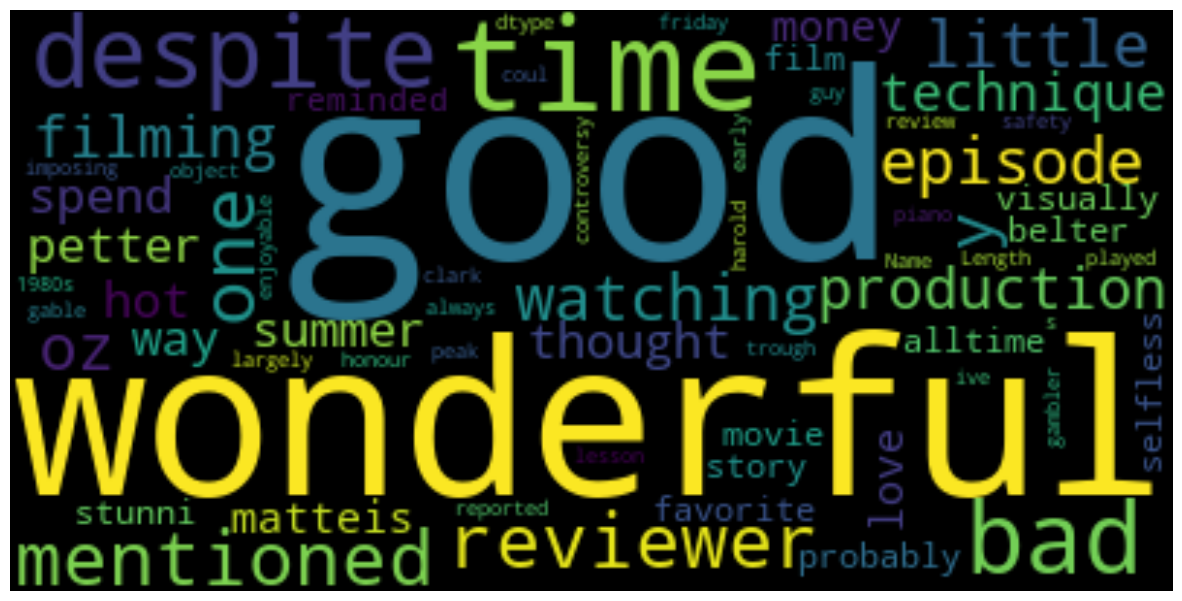

In [32]:
a=str(df[df["target"]==1]['review'])
wordcloud = WordCloud().generate(a)
plt.figure(figsize=(15,17))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Negative

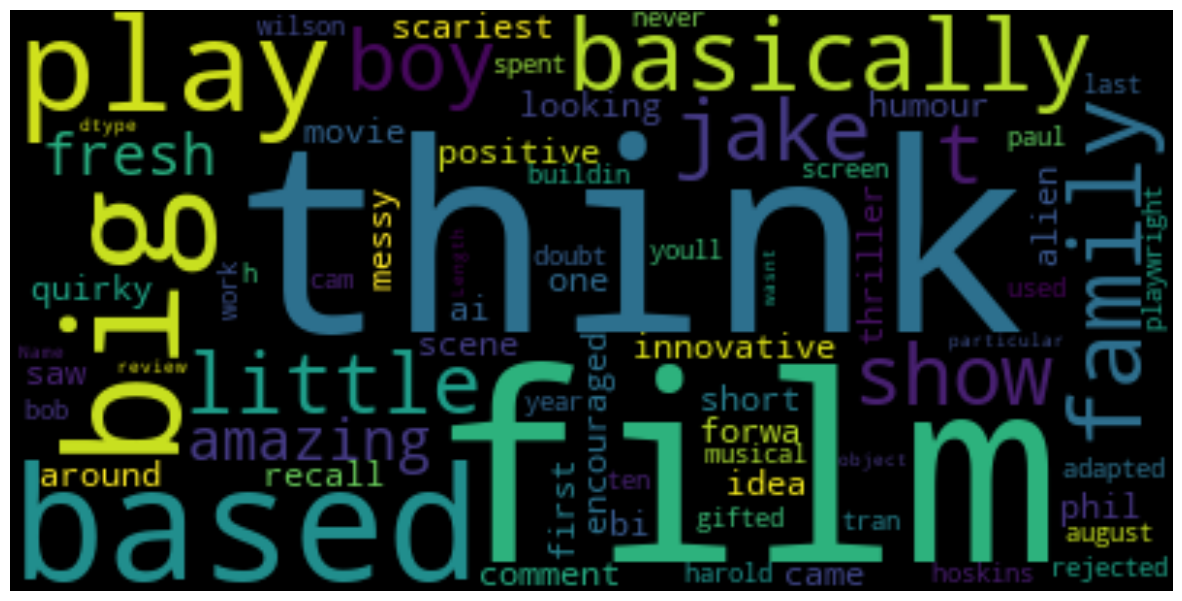

In [33]:
b=str(df[df["target"]==0]['review'])
wordcloud = WordCloud().generate(b)
plt.figure(figsize=(15,17))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Split the data

In [34]:
x=df['review']
y=df['target']

### Train-test split

In [35]:
 x_train, x_test, y_train, y_test= train_test_split(x,y,test_size=0.2,random_state=42)

##                  TF-IDF Vectorizer

In [36]:
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2), stop_words='english')
x_train_vec = vectorizer.fit_transform(x_train)
x_test_vec = vectorizer.transform(x_test)

In [37]:
with open("tf_idf_vectorizer.pkl","wb") as file:
    pickle.dump(vectorizer,file)

### Model Building

In [38]:
#Logistic model
def create_logistic_model(): 
    model=LogisticRegressionCV(max_iter=1000) 
    model.fit(x_train_vec,y_train) 
    return model 

#Naive-Bayes model
def create_naive_model(): 
    model=MultinomialNB() 
    model.fit(x_train_vec.toarray(),y_train) 
    return model

# KNN model
def create_knn_model():
    model=KNeighborsClassifier(n_neighbors=5) 
    model.fit(x_train_vec.toarray(),y_train) 
    return model 

#SVM model
def create_svm_model(): 
    model=LinearSVC()
    model.fit(x_train_vec,y_train) 
    return model

#SGD model
def create_SGD_model(): 
    model = SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3)
    model.fit(x_train_vec, y_train)
    return model
    
# XGboost model (boosting)
def create_xgboost_model(): 
    model= XGBClassifier(n_estimators=35,max_depth=2, learning_rate=0.2) 
    model.fit(x_train_vec,y_train)
    return model

#AdaBoost model
def create_adaboost_model():
    model = AdaBoostClassifier(n_estimators=35, learning_rate=0.2)
    model.fit(x_train_vec, y_train)
    return model

### Evaluate models

#### Testing evaluation

In [39]:
 def evaluate_model_test(model,model_name):
     if model_name in ['logistic regression','SGD Model','svm','xgboost','adaboost']:
         x_input=x_test_vec
     else:
         x_input=x_test_vec.toarray()
     y_pred=model.predict(x_input) 
     accuracy=accuracy_score(y_test,y_pred) 
     precision=precision_score(y_test,y_pred,average='binary') 
     recall=recall_score(y_test,y_pred,average='binary') 
     f1=f1_score(y_test,y_pred,average='binary') 
     return f"{accuracy:.2f}", f"{precision:.2f}", f"{recall:.2f}", f"{f1:.2f}"

#### Training Evaluation

In [40]:
 def evaluate_model(model,model_name):
     if model_name in ['logistic regression','SGD Model','svm','xgboost','adaboost']:
        x_input=x_train_vec
     else:
        x_input=x_train_vec.toarray()
     y_pred_train=model.predict(x_input) 
     accuracy=accuracy_score(y_train,y_pred_train) 
     precision=precision_score(y_train,y_pred_train) 
     recall=recall_score(y_train,y_pred_train) 
     f1=f1_score(y_train,y_pred_train) 
     return f"{accuracy:.2f}", f"{precision:.2f}", f"{recall:.2f}", f"{f1:.2f}"

In [41]:
models=[]
models.append({'name':'logistic regression', 'model':create_logistic_model()}) 
models.append({'name':'naive bayes', 'model':create_naive_model()})
models.append({'name':'svm', 'model':create_svm_model()}) 
models.append({'name':'knn', 'model':create_knn_model()}) 
models.append({'name':'SGD Model', 'model':create_SGD_model()})  
models.append({'name':'xgboost', 'model':create_xgboost_model()}) 
models.append({'name':'adaboost', 'model':create_adaboost_model()})

In [42]:
for info in models: 
    accuracy, precision , recall, f1= evaluate_model_test(info["model"], info['name']) 
    info['accuracy']=accuracy
    info['precision']=precision 
    info['recall']=recall 
    info['f1']=f1
df_evaluation_for_test=pd.DataFrame(models, columns=['name','accuracy','precision', 'recall','f1']);df_evaluation_for_test

,name,accuracy,precision,recall,f1
0,logistic regression,0.87,0.86,0.90,0.88
1,naive bayes,0.83,0.82,0.89,0.85
2,svm,0.86,0.86,0.89,0.87
3,knn,0.54,0.54,1.00,0.70
4,SGD Model,0.86,0.84,0.91,0.87
5,xgboost,0.75,0.71,0.90,0.80
6,adaboost,0.65,0.62,0.91,0.74


In [43]:
for info in models: 
    accuracy, precision , recall, f1= evaluate_model(info["model"],info['name']) 
    info['accuracy']=accuracy
    info['precision']=precision 
    info['recall']=recall 
    info['f1']=f1
df_evaluation_for_train=pd.DataFrame(models, columns=['name','accuracy','precision', 'recall','f1']);df_evaluation_for_train

,name,accuracy,precision,recall,f1
0,logistic regression,0.91,0.90,0.93,0.92
1,naive bayes,0.85,0.84,0.90,0.87
2,svm,0.93,0.93,0.94,0.94
3,knn,0.55,0.55,1.00,0.71
4,SGD Model,0.87,0.86,0.92,0.89
5,xgboost,0.75,0.72,0.90,0.80
6,adaboost,0.65,0.62,0.90,0.74


In [44]:
import pickle 
with open("final_model_lr.pkl","wb") as file:
    pickle.dump(models[0]['model'],file)

## Hybrid CV-TF-IDF

In [45]:
cv=CountVectorizer()
x_train_cv=cv.fit_transform(x_train)
x_test_cv = cv.transform(x_test)
vectorizer = TfidfVectorizer(vocabulary=cv.vocabulary_, max_features=10000)
x_train_vec = vectorizer.fit_transform(x_train)
x_test_vec = vectorizer.transform(x_test)
# convert sparse metrices to dense and take average
x_train_hybrid = (x_train_cv + x_train_vec) * 0.5
x_test_hybrid = (x_test_cv + x_test_vec) * 0.5

### Model building

In [46]:
#Logistic model
def create_logistic_model(): 
    model=LogisticRegressionCV(max_iter=1000) 
    model.fit(x_train_hybrid,y_train) 
    return model 

#Decision tree model
def create_Dtree_model(): 
    model=DecisionTreeClassifier(max_depth=10) 
    model.fit(x_train_hybrid,y_train) 
    return model

#Random Forest model (Bagging)
def create_random_forest_model(): 
    model=RandomForestClassifier(n_estimators=100,max_depth=10) 
    model.fit(x_train_hybrid,y_train)
    return model

# XGboost model (boosting)
def create_xgboost_model(): 
    model= XGBClassifier(n_estimators=35,max_depth=2, learning_rate=0.2) 
    model.fit(x_train_hybrid,y_train)
    return model

#AdaBoost model
def create_adaboost_model():
    model = AdaBoostClassifier(n_estimators=35, learning_rate=0.2)
    model.fit(x_train_hybrid, y_train)
    return model

### Evaluate model 

#### Testing evaluation

In [47]:
def evaluate_hybrid_model_test(model,model_name):
     # if model_name in ['logistic regression','xgboost','adaboost']:
     #     x_input_hybrid=x_test_hybrid
     # else:
     #     x_input_hybrid=x_test_hybrid.toarray()
     y_pred_hybrid=model.predict(x_test_hybrid) 
     accuracy=accuracy_score(y_test,y_pred_hybrid) 
     precision=precision_score(y_test,y_pred_hybrid) 
     recall=recall_score(y_test,y_pred_hybrid) 
     f1=f1_score(y_test,y_pred_hybrid) 
     return f"{accuracy:.2f}", f"{precision:.2f}", f"{recall:.2f}", f"{f1:.2f}"

#### Training evaluation

In [48]:
def evaluate_hybrid_model(model,model_name):
     # if model_name in ['logistic regression','xgboost','adaboost']:
     #    x_input_hybrid=x_train_hybrid
     # else:
     #    x_input_hybrid=x_train_hybrid.toarray()
     y_pred_train_hybrid=model.predict(x_train_hybrid) 
     accuracy=accuracy_score(y_train,y_pred_train_hybrid) 
     precision=precision_score(y_train,y_pred_train_hybrid) 
     recall=recall_score(y_train,y_pred_train_hybrid) 
     f1=f1_score(y_train,y_pred_train_hybrid) 
     return f"{accuracy:.2f}", f"{precision:.2f}", f"{recall:.2f}", f"{f1:.2f}"

In [49]:
models_hybrid=[]
models_hybrid.append({'name':'logistic regression', 'model':create_logistic_model()}) 
models_hybrid.append({'name':'decision tree', 'model':create_Dtree_model()}) 
models_hybrid.append({'name':'random forest', 'model':create_random_forest_model()}) 
models_hybrid.append({'name':'xgboost', 'model':create_xgboost_model()}) 
models_hybrid.append({'name':'adaboost', 'model':create_adaboost_model()})

In [50]:
for info in models_hybrid: 
    accuracy, precision , recall, f1= evaluate_hybrid_model_test(info["model"], info['name']) 
    info['accuracy']=accuracy
    info['precision']=precision 
    info['recall']=recall 
    info['f1']=f1
df_evaluation_hybrid_for_test=pd.DataFrame(models_hybrid, columns=['name','accuracy','precision', 'recall','f1']);df_evaluation_hybrid_for_test

,name,accuracy,precision,recall,f1
0,logistic regression,0.87,0.86,0.90,0.88
1,decision tree,0.72,0.69,0.86,0.77
2,random forest,0.65,0.61,0.99,0.75
3,xgboost,0.76,0.72,0.90,0.80
4,adaboost,0.65,0.62,0.94,0.74


In [51]:
for info in models_hybrid: 
    accuracy, precision , recall, f1= evaluate_hybrid_model(info["model"],info['name']) 
    info['accuracy']=accuracy
    info['precision']=precision 
    info['recall']=recall 
    info['f1']=f1
df_evaluation_hybrid_for_train=pd.DataFrame(models_hybrid, columns=['name','accuracy','precision', 'recall','f1']);df_evaluation_hybrid_for_train

,name,accuracy,precision,recall,f1
0,logistic regression,0.95,0.95,0.96,0.96
1,decision tree,0.74,0.71,0.89,0.79
2,random forest,0.67,0.62,1.00,0.76
3,xgboost,0.76,0.72,0.90,0.80
4,adaboost,0.65,0.62,0.93,0.74


## Count Vectorization

In [52]:
cv=CountVectorizer()
x_train_cv=cv.fit_transform(x_train)
x_test_cv = cv.transform(x_test)

In [53]:
svd = TruncatedSVD(n_components=500)
x_train_reduced = svd.fit_transform(x_train_cv)
x_test_reduced = svd.transform(x_test_cv)

In [54]:
#Logistic model
def create_logistic_model(): 
    model=LogisticRegressionCV(max_iter=1000) 
    model.fit(x_train_cv,y_train) 
    return model 

#Naive-Bayes model
def create_naive_model(): 
    model=MultinomialNB() 
    model.fit(x_train_cv,y_train) 
    return model
     
#Decision tree model
def create_Dtree_model(): 
    model=DecisionTreeClassifier(max_depth=10) 
    model.fit(x_train_reduced,y_train) 
    return model

#Random Forest model (Bagging)
def create_random_forest_model(): 
    model=RandomForestClassifier(n_estimators=100,max_depth=10) 
    model.fit(x_train_reduced,y_train)
    return model


In [55]:
#model.svd = svd  # store transformer for later use
# Example for Decision Tree prediction
# model = create_Dtree_model()
# x_test_reduced = model.svd.transform(x_test_cv)
# y_pred = model.predict(x_test_reduced)


In [56]:
def evaluate_cv_model_test(model,model_name):
     if model_name in ['decision tree','random forest']:
         x_input_cv=x_test_reduced
     else:
         x_input_cv=x_test_cv
     y_pred_cv=model.predict(x_input_cv) 
     accuracy_cv=accuracy_score(y_test,y_pred_cv) 
     precision_cv=precision_score(y_test,y_pred_cv) 
     recall_cv=recall_score(y_test,y_pred_cv) 
     f1_cv=f1_score(y_test,y_pred_cv) 
     return f"{accuracy_cv:.2f}", f"{precision_cv:.2f}", f"{recall_cv:.2f}", f"{f1_cv:.2f}"

In [57]:
def evaluate_cv_model(model,model_name):
     if model_name in ['decision tree','random forest']:
        x_input_cv=x_train_reduced
     else:
        x_input_cv=x_train_cv
     y_pred_train_cv=model.predict(x_input_cv) 
     accuracy_cv=accuracy_score(y_train,y_pred_train_cv) 
     precision_cv=precision_score(y_train,y_pred_train_cv) 
     recall_cv=recall_score(y_train,y_pred_train_cv) 
     f1_cv=f1_score(y_train,y_pred_train_cv) 
     return f"{accuracy_cv:.2f}", f"{precision_cv:.2f}", f"{recall_cv:.2f}", f"{f1_cv:.2f}"

In [58]:
models_cv=[]
models_cv.append({'name':'logistic regression', 'model':create_logistic_model()}) 
models_cv.append({'name':'Multinomial naive bayes', 'model':create_naive_model()})
models_cv.append({'name':'decision tree', 'model':create_Dtree_model()}) 
models_cv.append({'name':'random forest', 'model':create_random_forest_model()}) 
#models_cv.append({'name':'xgboost', 'model':create_random_xgboost_model()})

In [59]:
for info in models_cv: 
    accuracy_cv, precision_cv , recall_cv, f1_cv= evaluate_cv_model_test(info["model"], info['name']) 
    info['accuracy']=accuracy_cv
    info['precision']=precision_cv 
    info['recall']=recall_cv 
    info['f1']=f1_cv
df_evaluation_cv_for_test=pd.DataFrame(models_cv, columns=['name','accuracy','precision', 'recall','f1']);df_evaluation_cv_for_test

,name,accuracy,precision,recall,f1
0,logistic regression,0.87,0.86,0.90,0.88
1,Multinomial naive bayes,0.83,0.85,0.83,0.84
2,decision tree,0.65,0.67,0.69,0.68
3,random forest,0.73,0.70,0.88,0.78


In [60]:
for info in models_cv: 
    accuracy_cv, precision_cv , recall_cv, f1_cv= evaluate_cv_model(info["model"],info['name']) 
    info['accuracy']=accuracy_cv
    info['precision']=precision_cv 
    info['recall']=recall_cv 
    info['f1']=f1_cv
df_evaluation_cv_for_train=pd.DataFrame(models_cv, columns=['name','accuracy','precision', 'recall','f1']);df_evaluation_cv_for_train

,name,accuracy,precision,recall,f1
0,logistic regression,0.93,0.92,0.95,0.94
1,Multinomial naive bayes,0.89,0.91,0.87,0.89
2,decision tree,0.78,0.79,0.82,0.81
3,random forest,0.88,0.84,0.97,0.90


In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import nltk
from nltk.tokenize import word_tokenize

# Download tokenizer
nltk.download('punkt')

# -------------------------------
# Reset indexes to fix KeyError
# -------------------------------
x_train = x_train.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)
y_train = pd.Series(y_train).reset_index(drop=True)
y_test = pd.Series(y_test).reset_index(drop=True)

# -------------------------------
# Tokenizer and Vocabulary Builder
# -------------------------------
def tokenize(text):
    return word_tokenize(text.lower())

class Vocab:
    def __init__(self, texts, max_vocab_size=20000):
        counter = Counter()
        for text in texts:
            tokens = tokenize(text)
            counter.update(tokens)
        most_common = counter.most_common(max_vocab_size - 2)
        self.itos = ['<PAD>', '<UNK>'] + [word for word, _ in most_common]
        self.stoi = {word: idx for idx, word in enumerate(self.itos)}

    def numericalize(self, text):
        return [self.stoi.get(token, self.stoi['<UNK>']) for token in tokenize(text)]

# -------------------------------
# Dataset Class
# -------------------------------
class TextDataset(Dataset):
    def __init__(self, texts, labels, vocab):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        tokens = torch.tensor(self.vocab.numericalize(self.texts[idx]), dtype=torch.long)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return tokens, label

def collate_batch(batch):
    texts = [item[0] for item in batch]
    labels = torch.tensor([item[1] for item in batch], dtype=torch.long)
    padded_texts = pad_sequence(texts, batch_first=True, padding_value=0)
    return padded_texts, labels

# -------------------------------
# Feedforward Neural Network Model
# -------------------------------
class FFNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.fc = nn.Sequential(
            nn.Linear(embed_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        embedded = self.embedding(x)
        pooled = embedded.mean(dim=1)
        return self.fc(pooled)

# -------------------------------
# Training and Evaluation
# -------------------------------
def train_model(model, dataloader, loss_fn, optimizer, device):
    model.train()
    for x_batch, y_batch in dataloader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(x_batch)
        loss = loss_fn(output, y_batch)
        loss.backward()
        optimizer.step()

def evaluate_model(model, dataloader, device, label_encoder):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            output = model(x_batch)
            preds = output.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(y_batch.numpy())

    target_names = [str(cls) for cls in label_encoder.classes_]  # Ensure labels are strings
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=target_names))


# -------------------------------
# Main Execution
# -------------------------------
# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# Build vocabulary
vocab = Vocab(x_train)

# Create datasets and loaders
train_dataset = TextDataset(x_train, y_train_enc, vocab)
test_dataset = TextDataset(x_test, y_test_enc, vocab)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=64, collate_fn=collate_batch)

# Model setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FFNN(vocab_size=len(vocab.itos), embed_dim=128, num_classes=len(le.classes_)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Train
for epoch in range(5):
    print(f"\nEpoch {epoch+1}")
    train_model(model, train_loader, loss_fn, optimizer, device)

# Evaluate
evaluate_model(model, test_loader, device, le)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kaila\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!



Epoch 1

Epoch 2

Epoch 3

Epoch 4

Epoch 5

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.84      0.85      6200
           1       0.86      0.90      0.88      7160

    accuracy                           0.87     13360
   macro avg       0.87      0.87      0.87     13360
weighted avg       0.87      0.87      0.87     13360



In [62]:
A

0        one reviewer mentioned watching 1 oz episode y...
1        wonderful little production filming technique ...
2        thought wonderful way spend time hot summer we...
3        basically there family little boy jake think t...
4        petter matteis love time money visually stunni...
                               ...                        
66792    safety honour early 1980s good friday harold s...
66793    harold bob hoskins spent last ten year buildin...
66794    ive always bad guy bad gambler would like good...
66795    think used like musical else particular wasnt ...
66796    despite reported controversy played enjoyable ...
Name: review, Length: 66797, dtype: object

In [63]:
df

,review,sentiment,target
0,one reviewer mentioned watching 1 oz episode y...,positive,1
1,wonderful little production filming technique ...,positive,1
2,thought wonderful way spend time hot summer we...,positive,1
3,basically there family little boy jake think t...,negative,0
4,petter matteis love time money visually stunni...,positive,1
...,...,...,...
66792,safety honour early 1980s good friday harold s...,positive,1
66793,harold bob hoskins spent last ten year buildin...,negative,0
66794,ive always bad guy bad gambler would like good...,positive,1
66795,think used like musical else particular wasnt ...,negative,0


In [66]:
import pandas as pd
from nltk.tokenize import word_tokenize
from textblob import TextBlob
import nltk
nltk.download('punkt')




def extract_features(review):
    tokens = word_tokenize(review.lower())
    length = len(review)
    word_count = len(tokens)
    avg_word_len = length / word_count if word_count > 0 else 0
    blob = TextBlob(review)
    polarity = blob.sentiment.polarity
    subjectivity = blob.sentiment.subjectivity
    exclamations = review.count('!')
    questions = review.count('?')
    
    return pd.Series([length, word_count, avg_word_len, polarity, subjectivity, exclamations, questions])

df[['char_count', 'word_count', 'avg_word_len', 'polarity', 'subjectivity', 'exclamations', 'questions']] = df['review'].apply(extract_features)
new_df=pd.DataFrame(df,columns=['review','sentiment','target','char_count', 'word_count', 'avg_word_len', 'polarity', 'subjectivity', 'exclamations', 'questions'])
print(new_df)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kaila\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


                                                  review sentiment  target  \
0      one reviewer mentioned watching 1 oz episode y...  positive       1   
1      wonderful little production filming technique ...  positive       1   
2      thought wonderful way spend time hot summer we...  positive       1   
3      basically there family little boy jake think t...  negative       0   
4      petter matteis love time money visually stunni...  positive       1   
...                                                  ...       ...     ...   
66792  safety honour early 1980s good friday harold s...  positive       1   
66793  harold bob hoskins spent last ten year buildin...  negative       0   
66794  ive always bad guy bad gambler would like good...  positive       1   
66795  think used like musical else particular wasnt ...  negative       0   
66796  despite reported controversy played enjoyable ...  positive       1   

       char_count  word_count  avg_word_len  polarity  subjecti

In [68]:
new_df.to_csv("data_visual.csv", index=False)